## Final Project 
## Brainster DS x Parkinson's Disease Specifications

### Import libraries

In [164]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB,GaussianNB
from sklearn.metrics import roc_auc_score,f1_score,accuracy_score,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Import data from DataLoad nootbook

In [165]:
df_users = pd.read_csv("df_user.csv")
df_keys = pd.read_csv("df_keys.csv")

### Agregate data on HoldTime and FlightTime by user

In [166]:
hold_by_user =  df_keys[df_keys['Hand'] != 'S'].groupby(['ID', 'Hand'])['HoldTime'].agg(['mean'])
FlightTime_by_user = df_keys[np.in1d(df_keys['Direction'], ['LL', 'LR', 'RL', 'RR'])].groupby(['ID', 'Direction'])['FlightTime'].agg(['mean'])

In [167]:
hold_by_user_flat = hold_by_user.unstack()
hold_by_user_flat.columns = ['_'.join(col).strip() for col in hold_by_user_flat.columns.values]

In [168]:
FlightTime_by_user_flat = FlightTime_by_user.unstack()
FlightTime_by_user_flat.columns = ['_'.join(col).strip() for col in FlightTime_by_user_flat.columns.values]

### Conect FlightTime and HoldTime

In [169]:
combined = pd.concat([hold_by_user_flat, FlightTime_by_user_flat], axis=1)

### Merge combined with df_users

In [170]:
full_set = pd.merge(combined.reset_index(), df_users[['ID', 'Parkinsons']], on='ID')


In [171]:
full_set['Parkinsons'] = full_set['Parkinsons'].astype(int)

### Save full_set

In [172]:
full_set.to_csv('full_set_FligthTime.csv', index=False) 

### Train model

In [173]:
X = full_set.drop(columns=['Parkinsons','ID'])
y = full_set['Parkinsons']

### Split data to train and test

In [174]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [175]:
X_ber=X_train.values
y_ber = y_train.values
X_test_ber=X_test.values
y_test_ber = y_test.values

### Train model with Bernoulli

In [176]:
bnb = BernoulliNB(alpha=0.058, force_alpha=False, binarize=0.0016)
model_bernuoli = bnb.fit(X_train, y_train)

### Predict model and scores 

In [177]:
y_pred_ber = bnb.predict(X_test_ber)
pred_ber = bnb.predict_proba(X_test_ber)
auc = roc_auc_score(y_test_ber, pred_ber[:, 1])
accuracy = accuracy_score(y_test, y_pred_ber)
f1 = f1_score(y_test, y_pred_ber, average='weighted')
print(f"Accuracy: {accuracy:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f'AUC score: {auc:.3f}')

Accuracy: 0.588
F1-Score: 0.436
AUC score: 0.500


### Save model

In [178]:
filename = 'BernoulliNB.sav'
pickle.dump(bnb, open(filename, 'wb'))


### Train model with Logistic Regression
#### Scale data 

In [179]:
scaler = StandardScaler()
X_train_log= scaler.fit_transform(X_train)
X_test_log = scaler.transform(X_test)

In [180]:
model_Logistic = LogisticRegression()
model_Logistic.fit(X_train_log, y_train)

LogisticRegression()

### Predict model and scores

In [181]:
y_pred_log = model_Logistic.predict(X_test_log)
auc = roc_auc_score(y_test,y_pred_log )
accuracy = accuracy_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log, average='weighted')
print(f"Accuracy: {accuracy:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f'AUC score: {auc:.3f}')

Accuracy: 0.588
F1-Score: 0.515
AUC score: 0.521


In [182]:
filename = 'LogisticRegression.sav'
pickle.dump(bnb, open(filename, 'wb'))


In [183]:
gnb = GaussianNB(var_smoothing=0.00000008)
gnb.fit(X_train, y_train)

GaussianNB(var_smoothing=8e-08)

In [184]:
y_pred_gnb = gnb.predict(X_test)
auc = roc_auc_score(y_test,y_pred_gnb )
accuracy = accuracy_score(y_test, y_pred_gnb)
f1 = f1_score(y_test, y_pred_gnb, average='weighted')
print(f"Accuracy: {accuracy:.3f}")
print(f"F1-Score: {f1:.3f}")
print(f'AUC score: {auc:.3f}')

Accuracy: 0.353
F1-Score: 0.330
AUC score: 0.386


In [185]:
filename = 'GaussianNB.sav'
pickle.dump(gnb, open(filename, 'wb'))

In [186]:
Y_gnb_score = gnb.predict_proba(X_test)
Y_bnb_score = bnb.predict_proba(X_test_ber)
# Y_lr_score = bnb.decision_function(X_test)
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_test, Y_gnb_score[:, 1])
fpr_bnb, tpr_bnb, thresholds_bnb = roc_curve(y_test, Y_bnb_score[:, 1])

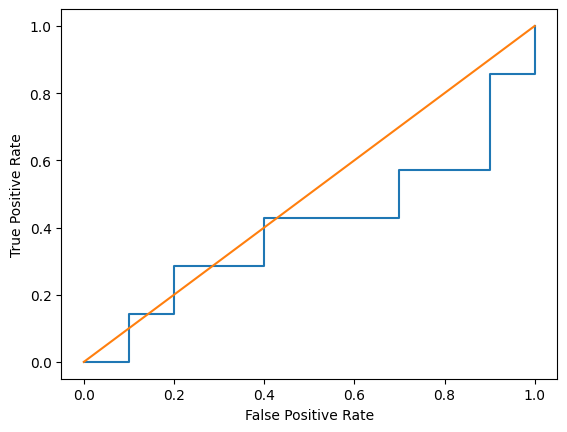

In [187]:
plt.plot(fpr_gnb,tpr_gnb)
plt.plot(fpr_bnb,tpr_bnb)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()